### Benchmarking 3 gcd implementations against each other 

- `Nemo.gcdx` -- some EEA algorithm from the flint library;
- `ExactSparseInterpolations.fastgcd` - fast gcd from the Modern Comp. Algebra;
- `ExactSparseInterpolations.slowgcd` - standard implementation of thw EEA.

Over integers modulo a prime number.


In [1]:
# include the ExactSparseInterpolations package from the local dir 
include("../src/ExactSparseInterpolations.jl");

In [2]:
using Nemo
using BenchmarkTools
using Plots
using DataFrames

In [3]:
# Given the function `GCD` and the range `ns`
# benchmark the function `GCD` on polynomials of degrees 2^n for n in `ns` 
# and return the array of running times
function benchmark_gcd(GCD, ns)
    R, x = PolynomialRing(GF(2^31-1), "x")
    times = Float64[]
    for i in ns
        n = 2^i
        a, b, c = div(n, 3), div(n, 6), div(n, 2)
        @assert a + b + c <= n
        f = (x - 1)^a*(x + 4)^b*(x + 3)^c
        g = (x - 1)^b*(x + 3)^a*(x + 7)^c
        bench = @benchmarkable $GCD($f, $g) samples=3
        push!(times, minimum(run(bench)).time)
    end
    times
end

benchmark_gcd (generic function with 1 method)

### Benchmark the three functions:

In [6]:
# grid 2..13
ns = 2:15

2:15

In [9]:
nemo_gcd = benchmark_gcd(Nemo.gcdx, ns);

In [10]:
esi_fast_gcd = benchmark_gcd(ExactSparseInterpolations.fastgcd, ns);

In [11]:
esi_slow_gcd = benchmark_gcd(ExactSparseInterpolations.slowgcd, ns);

#### Plots the running times

in logarithmic scale in y-coordinate 

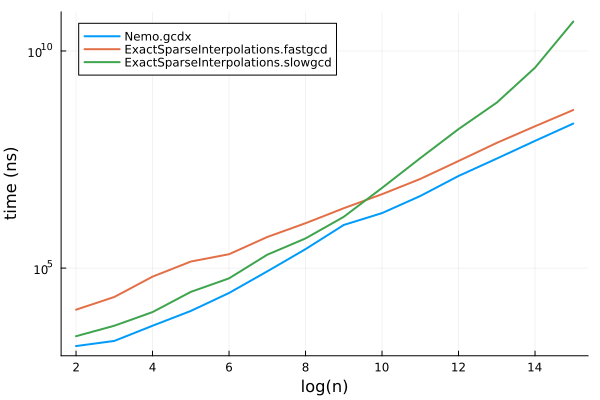

In [12]:
plot(ns, nemo_gcd, label="Nemo.gcdx", linewidth=2, legend=:topleft, yaxis=:log)
plot!(ns, esi_fast_gcd, label="ExactSparseInterpolations.fastgcd", linewidth=2)
plot!(ns, esi_slow_gcd, label="ExactSparseInterpolations.slowgcd", linewidth=2)
xlabel!("log(n)")
ylabel!("time (ns)")

#### The summary of running times:

in seconds

In [13]:
# convert from ns to s
df = DataFrame(
    degree=["2^$i" for i in ns], 
    nemo_gcd=round.(nemo_gcd ./ 1e9, digits=4), 
    esi_fast_gcd=round.(esi_fast_gcd ./ 1e9, digits=4), 
    esi_slow_gcd=round.(esi_slow_gcd ./ 1e9, digits=4)
)
df

Row,degree,nemo_gcd,esi_fast_gcd,esi_slow_gcd
,String,Float64,Float64,Float64
1,2^2,0.0,0.0,0.0
2,2^3,0.0,0.0,0.0
3,2^4,0.0,0.0001,0.0
4,2^5,0.0,0.0001,0.0
5,2^6,0.0,0.0002,0.0001
6,2^7,0.0001,0.0005,0.0002
7,2^8,0.0003,0.0011,0.0005
8,2^9,0.001,0.0024,0.0015
9,2^10,0.0018,0.005,0.007


#### What is the complexity of `Nemo.gcdx` implementation ?

Let's find the complexity of `Nemo.gcdx` as a function 

$$f(n) = aM(n)log~n + b \in \mathcal{O}(M(n)log~n)$$

If we assume for a moment that the function is linear, we can try to infer the constant $a$. That is, take some two points from the column `nemo_gcd` from the table: $(2^{11}, 46\cdot 10^{-4})$ and $(2^{12}, 132\cdot 10^{-4})$.

Since we assumed $f(n) = an + b$, the coefficient is obtained by plugging two points in $f(n)$. In our case,

$$
\begin{aligned}
46\cdot 10^{-4} = 2048a + b\\
132\cdot 10^{-4} = 4096a + b\\
\end{aligned}
$$
 
and we infer roughly

$$
\begin{aligned}
a &= (132 - 46) / 2\cdot 10^{-7} = 42\cdot 10^{-7}\\
b &= -4\cdot 10^{-3}\\
\end{aligned}
$$

Let's check if $f(n) = (n)log~n + b$ is close to the experimental values.

In [36]:
a = 42*1e-7
b = -4*1e-3
M(n) = n*log(n)
f(n) = a*M(n)*log(n) + b

f (generic function with 1 method)

In [39]:
df[!, "aM(n)logn"] = [max(0, f(2^n)) for n in ns];
df

Row,degree,nemo_gcd,esi_fast_gcd,esi_slow_gcd,aM(n)logn
,String,Float64,Float64,Float64,Float64
1,2^2,0.0,0.0,0.0,0.0
2,2^3,0.0,0.0,0.0,0.0
3,2^4,0.0,0.0001,0.0,0.0
4,2^5,0.0,0.0001,0.0,0.0
5,2^6,0.0,0.0002,0.0001,0.000649248
6,2^7,0.0001,0.0005,0.0002,0.00865629
7,2^8,0.0003,0.0011,0.0005,0.0290613
8,2^9,0.001,0.0024,0.0015,0.0796865
9,2^10,0.0018,0.005,0.007,0.202633


Not very close..